# Bitcoin´s time series analysis.

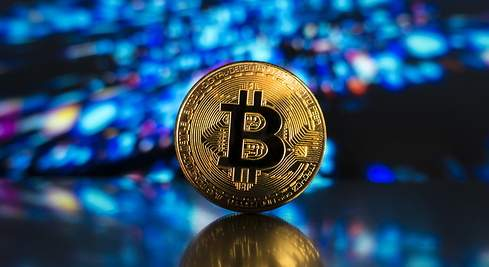

Tests applied throughout the document

**Dickey fuller test**

H0: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Ha: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent

**Shapiro test** 

H0: Data is normal distributed

Ha: Data isn´t normal distributed

**Ljung box test**

H0: our model does not show lack of fit (or in simple terms—the model is just fine)

Ha: model does show a lack of fit

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance
import scipy.stats
import pylab
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
import warnings
from pmdarima.arima import auto_arima
from datetime import datetime
import statsmodels.api as sm
warnings.filterwarnings("ignore")
sns.set()

**Introduction:** This proyect aims to find an econometric model that fits to bitcoin´s price.

In [2]:
def get_tickets_close(tickets, start_date, end_date):
    info = yfinance.download(tickers = tickets, interval ='1d',start= start_date, end =end_date, groub_by = 'ticker',auto_adjust = True, treads = True)['Close']
    return info

In [3]:
btc = get_tickets_close('BTC-USD', '2020-01-01', '2021-10-28')
btc

[*********************100%***********************]  1 of 1 completed


Date
2020-01-01     7200.174316
2020-01-02     6985.470215
2020-01-03     7344.884277
2020-01-04     7410.656738
2020-01-05     7411.317383
                  ...     
2021-10-24    60930.835938
2021-10-25    63039.824219
2021-10-26    60363.792969
2021-10-27    58482.386719
2021-10-28    60622.136719
Name: Close, Length: 663, dtype: float64

In [4]:
len(btc)

663

# Data visualization

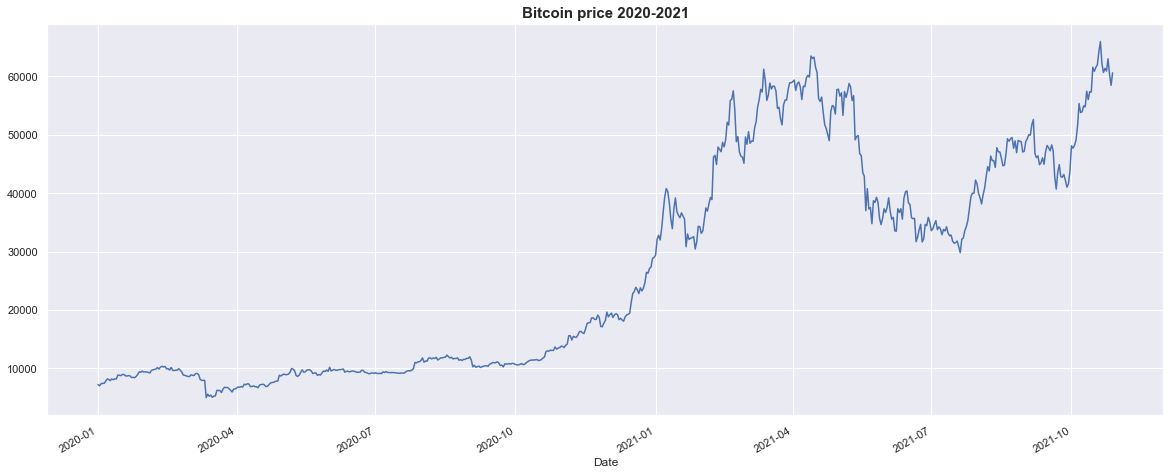

In [5]:
btc.plot(figsize=(20,8))
plt.title('Bitcoin price 2020-2021', fontsize=15, weight='bold')
plt.show()

# Training and test data

In [6]:
test=btc[-30:]

In [7]:
train=btc[:633]

In [8]:
len(test+train)

663

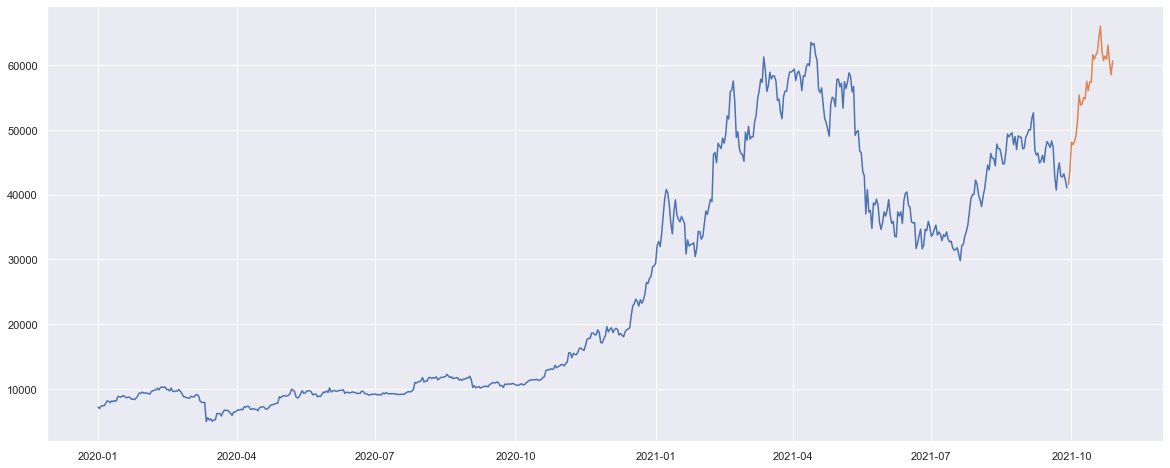

In [9]:
plt.figure(figsize=(20,8))
plt.plot(train)
plt.plot(test)
plt.show()

## Dickey fuller test

In [10]:
sts.adfuller(btc)

(-0.4595807479043685,
 0.8996656413227944,
 13,
 649,
 {'1%': -3.440466106307706,
  '5%': -2.8660036655537744,
  '10%': -2.569147085049656},
 11093.377778861648)

* As we can see in the plots, using 'Normal' or 'Real' prices of bitcoin results in a non-stationary process, but is not enough information to validate this hypothesis.

* We can see that the prices has a trend.

* Doesn´t have a constant volatility.

* We can assume that isn´t an hesteskssnn

## Transforming data to a stationary process

In [11]:
diff_btc = btc.diff().dropna()
sts.adfuller(diff_btc)

(-27.224813760166224,
 0.0,
 0,
 661,
 {'1%': -3.4402817347322583,
  '5%': -2.8659224464259823,
  '10%': -2.5691038118332603},
 11075.245786652573)

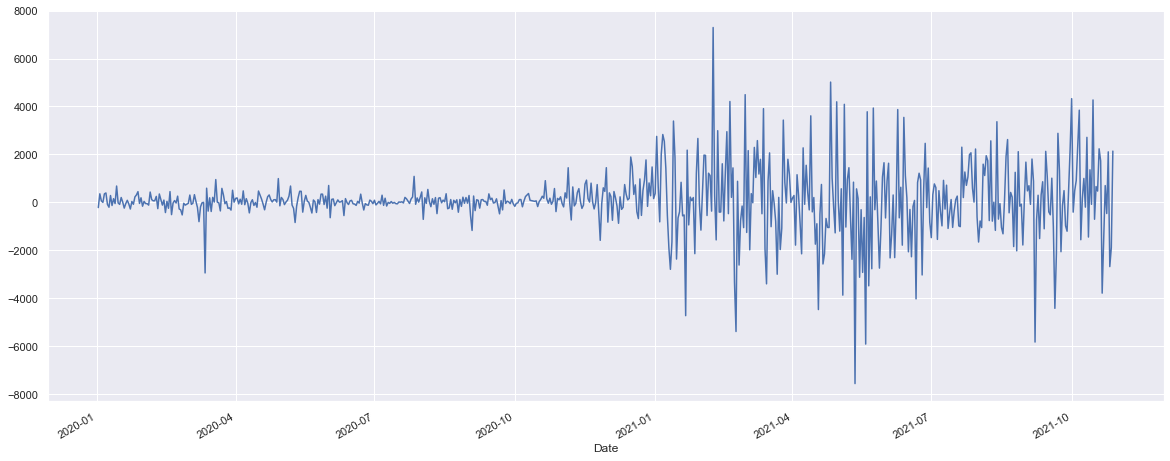

In [12]:
diff_btc.plot(figsize=(20,8))
plt.show()

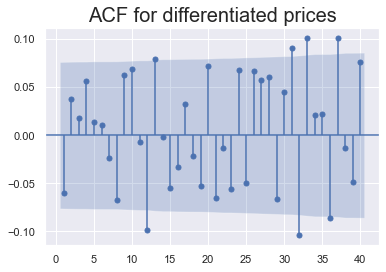

In [13]:
sgt.plot_acf(diff_btc, zero=False, lags=40)
plt.title("ACF for differentiated prices", size= 20)
plt.show()

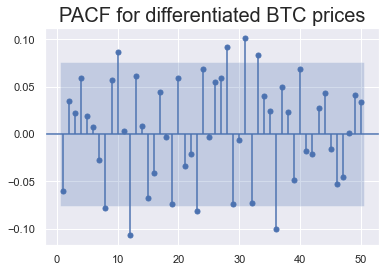

In [14]:
sgt.plot_pacf(diff_btc, lags = 50, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF for differentiated BTC prices", size = 20)
plt.show()

# Finding the best model

## Arima 510

In [15]:
model_arima510 = ARIMA(btc,order=(5,1,0))
results_model_510=model_arima510.fit()
print(results_model_510.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  662
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5704.820
Method:                       css-mle   S.D. of innovations           1337.553
Date:                Fri, 19 Nov 2021   AIC                          11423.640
Time:                        17:01:33   BIC                          11455.107
Sample:                             1   HQIC                         11435.835
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            80.6978     56.160      1.437      0.151     -29.374     190.770
ar.L1.D.Close    -0.0615      0.039     -1.582      0.114      -0.138       0.015
ar.L2.D.Close     0.0328      0.039     

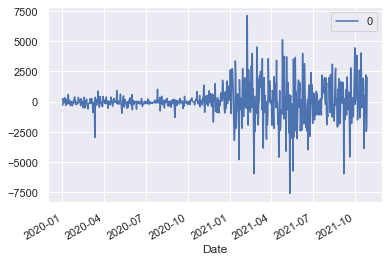

In [16]:
residuals_510 = pd.DataFrame(results_model_510.resid)
residuals_510.plot()
plt.show()

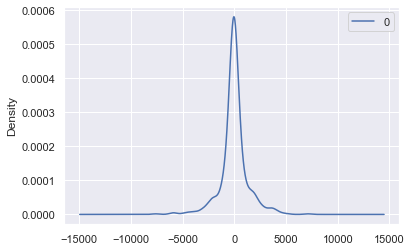

In [17]:
residuals_510.plot(kind='kde')
plt.show()

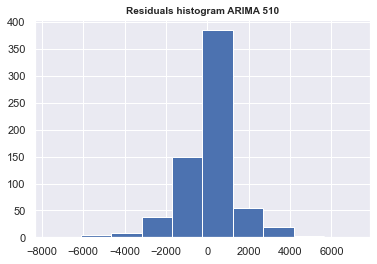

In [18]:
residuals_510.hist()
plt.title('Residuals histogram ARIMA 510', fontsize=10, weight='bold')
plt.show()

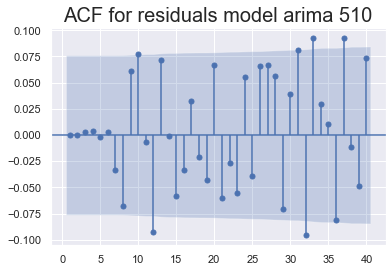

In [19]:
sgt.plot_acf(residuals_510, zero=False, lags=40)
plt.title("ACF for residuals model arima 510", size= 20)
plt.show()

In [20]:
sm.stats.acorr_ljungbox(residuals_510, lags=[5], return_df=True)

,lb_stat,lb_pvalue
5,0.018239,0.999998


In [21]:
shapiro_test_510 = stats.shapiro(residuals_510)
shapiro_test_510

ShapiroResult(statistic=0.8683976531028748, pvalue=3.7019920151144934e-23)

Shapiro´s test p-value is near 0, thus residuals are normal distributed.

<Figure size 1440x576 with 0 Axes>

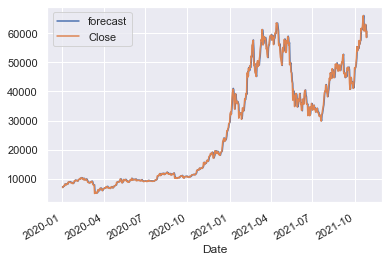

In [22]:
plt.figure(figsize=(20,8))
results_model_510.plot_predict(dynamic=False)
plt.show()

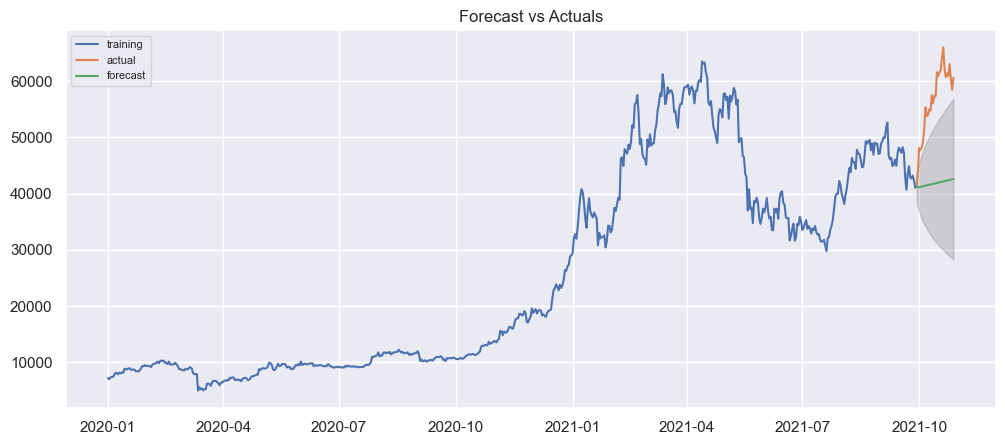

In [23]:
model_510 = ARIMA(train, order=(5, 1, 0))  
fitted = model_510.fit(disp=-1)
# Forecast
fc, se, conf = fitted.forecast(30, alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [24]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})
forecast_accuracy(fc, test.values)


{'mape': 0.2508051542979432,
 'me': -14676.876288384197,
 'mae': 14676.876288384197,
 'mpe': -0.2508051542979432,
 'rmse': 15761.875749930032,
 'acf1': 0.8283095962631337,
 'corr': 0.8568553287270254,
 'minmax': 0.25080515429794326}

## Arima 410

In [25]:
model_arima410 = ARIMA(btc,order=(4,1,0))
results_model_410=model_arima410.fit()
print(results_model_410.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  662
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -5704.943
Method:                       css-mle   S.D. of innovations           1337.804
Date:                Fri, 19 Nov 2021   AIC                          11421.886
Time:                        17:01:39   BIC                          11448.858
Sample:                             1   HQIC                         11432.339
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            80.6978     55.101      1.465      0.143     -27.299     188.695
ar.L1.D.Close    -0.0604      0.039     -1.555      0.120      -0.137       0.016
ar.L2.D.Close     0.0332      0.039     

In [26]:
residuals_410 = pd.DataFrame(results_model_410.resid)

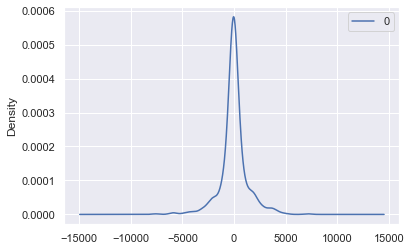

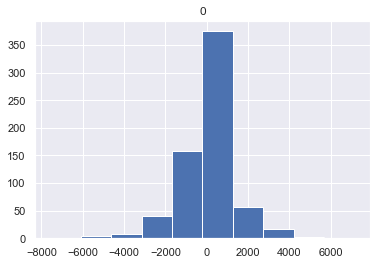

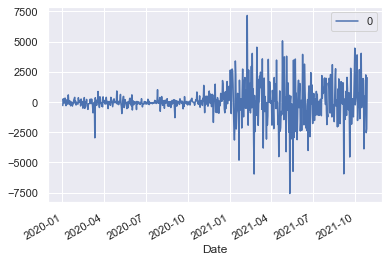

In [27]:
residuals_410.plot(kind='kde')
residuals_410.hist()
residuals_410.plot()
plt.show()

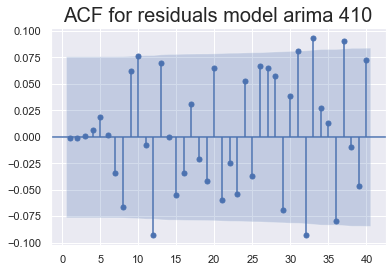

In [28]:
sgt.plot_acf(residuals_410, zero=False, lags=40)
plt.title("ACF for residuals model arima 410", size= 20)
plt.show()

In [29]:
sm.stats.acorr_ljungbox(residuals_410, lags=[4], return_df=True)

,lb_stat,lb_pvalue
4,0.027583,0.999906


<Figure size 1440x576 with 0 Axes>

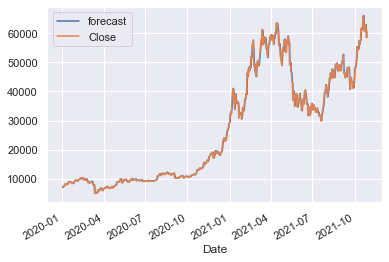

In [30]:
plt.figure(figsize=(20,8))
results_model_410.plot_predict(dynamic=False)
plt.show()

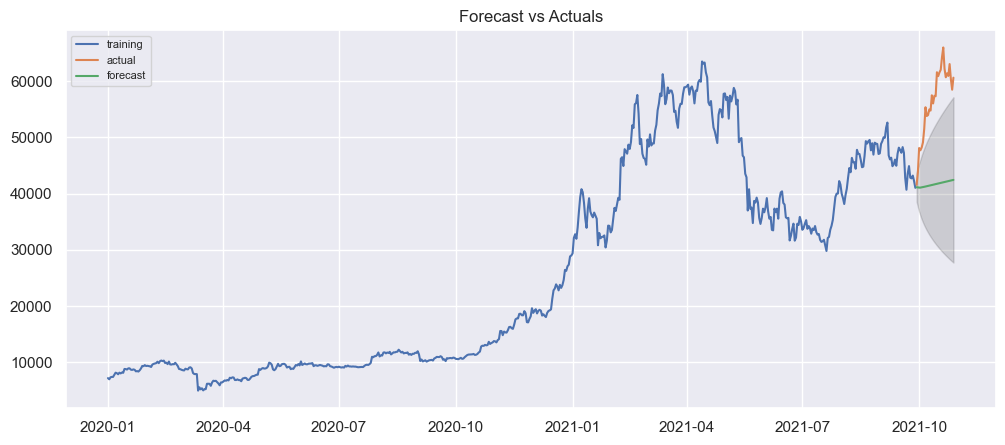

In [31]:
model_410 = ARIMA(train, order=(4, 1, 0))  
fitted = model_410.fit(disp=-1)
# Forecast
fc, se, conf = fitted.forecast(30, alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [32]:
forecast_accuracy(fc, test.values)

{'mape': 0.2533172961086485,
 'me': -14819.654363349084,
 'mae': 14819.654363349084,
 'mpe': -0.2533172961086485,
 'rmse': 15902.499904414233,
 'acf1': 0.828528021977854,
 'corr': 0.8408364658958684,
 'minmax': 0.2533172961086484}

## Arima 411

In [33]:
model_arima411 = ARIMA(btc,order=(4,1,1))
results_model_411=model_arima411.fit()
print(results_model_411.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  662
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -5704.838
Method:                       css-mle   S.D. of innovations           1337.589
Date:                Fri, 19 Nov 2021   AIC                          11423.676
Time:                        17:01:42   BIC                          11455.143
Sample:                             1   HQIC                         11435.871
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            80.6975     56.156      1.437      0.151     -29.366     190.761
ar.L1.D.Close     0.1751      0.445      0.393      0.694      -0.697       1.047
ar.L2.D.Close     0.0471      0.048     

In [34]:
residuals_411 = pd.DataFrame(results_model_411.resid)

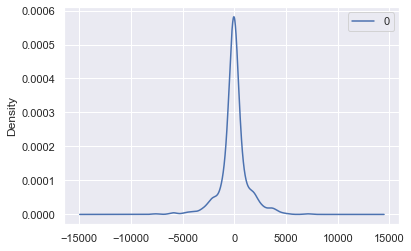

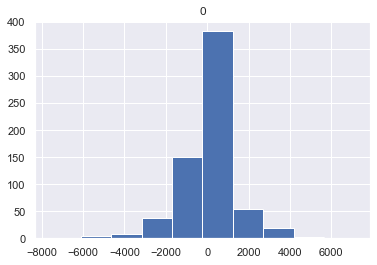

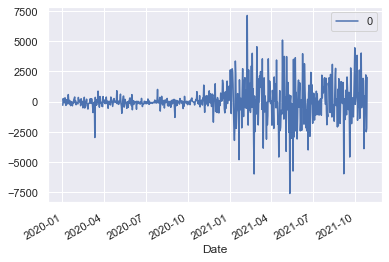

In [35]:
residuals_411.plot(kind='kde')
residuals_411.hist()
residuals_411.plot()
plt.show()

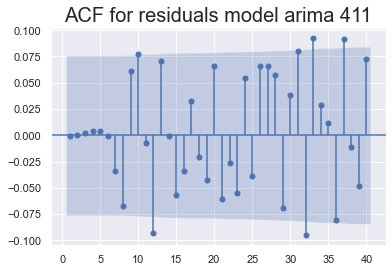

In [36]:
sgt.plot_acf(residuals_411, zero=False, lags=40)
plt.title("ACF for residuals model arima 411", size= 20)
plt.show()

In [37]:
sm.stats.acorr_ljungbox(residuals_410, lags=[4], return_df=True)

,lb_stat,lb_pvalue
4,0.027583,0.999906


In [38]:
shapiro_test_411 = stats.shapiro(residuals_411)
shapiro_test_411

ShapiroResult(statistic=0.8682215213775635, pvalue=3.5841295694428703e-23)

Shapiro´s test p-value is near 0, thus residuals are normal distributed.

<Figure size 1440x576 with 0 Axes>

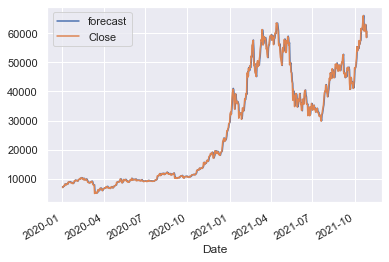

In [39]:
plt.figure(figsize=(20,8))
results_model_411.plot_predict(dynamic=False)
plt.show()

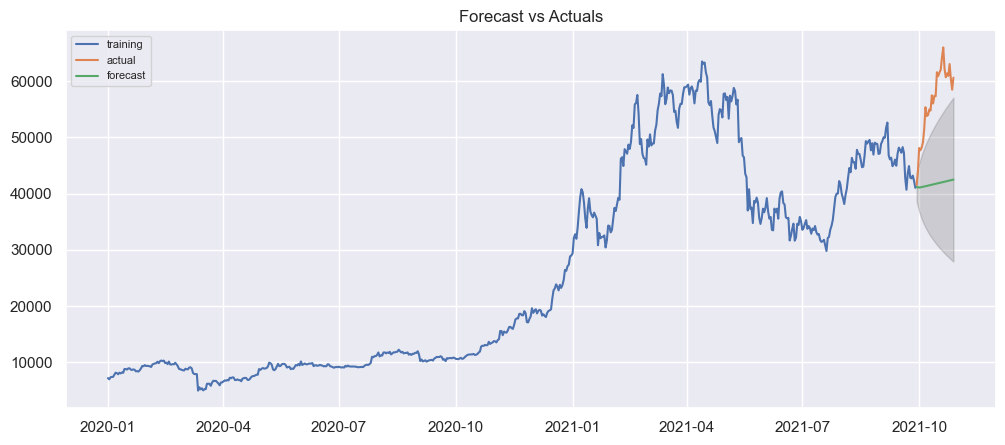

In [40]:
model_411 = ARIMA(train, order=(4, 1, 1))  
fitted = model_411.fit(disp=-1)
# Forecast
fc, se, conf = fitted.forecast(30, alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [41]:
forecast_accuracy(fc, test.values)

{'mape': 0.2524402598755681,
 'me': -14770.026864518868,
 'mae': 14770.026864518868,
 'mpe': -0.2524402598755681,
 'rmse': 15854.196050309984,
 'acf1': 0.8283063606597534,
 'corr': 0.8450216989039073,
 'minmax': 0.2524402598755682}

## Arima 310

In [42]:
model_arima310 = ARIMA(btc,order=(3,1,0))
results_model_310=model_arima310.fit()
print(results_model_310.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  662
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -5706.057
Method:                       css-mle   S.D. of innovations           1340.069
Date:                Fri, 19 Nov 2021   AIC                          11422.113
Time:                        17:01:45   BIC                          11444.590
Sample:                             1   HQIC                         11430.824
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            80.6978     52.025      1.551      0.121     -21.270     182.665
ar.L1.D.Close    -0.0593      0.039     -1.524      0.128      -0.136       0.017
ar.L2.D.Close     0.0357      0.039     

In [43]:
residuals_310 = pd.DataFrame(results_model_310.resid)

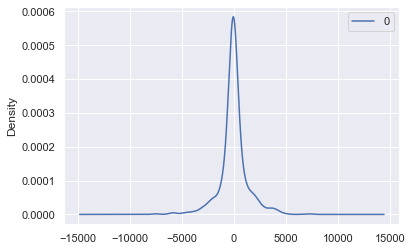

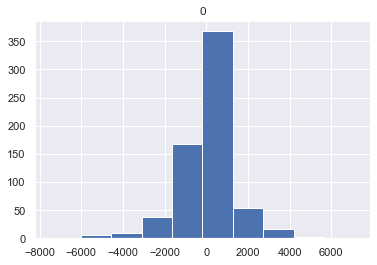

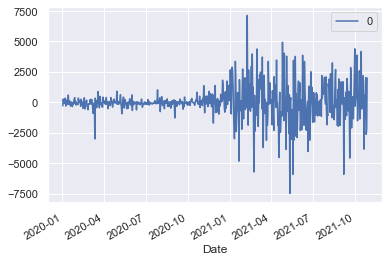

In [44]:
residuals_310.plot(kind='kde')
residuals_310.hist()
residuals_310.plot()
plt.show()

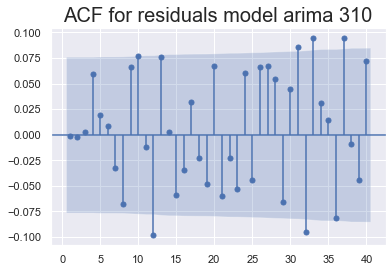

In [45]:
sgt.plot_acf(residuals_310, zero=False, lags=40)
plt.title("ACF for residuals model arima 310", size= 20)
plt.show()

In [46]:
sm.stats.acorr_ljungbox(residuals_310, lags=[4], return_df=True)

,lb_stat,lb_pvalue
4,2.320953,0.676957


In [47]:
shapiro_test_310 = stats.shapiro(residuals_310)
shapiro_test_310

ShapiroResult(statistic=0.8679945468902588, pvalue=3.437835945658358e-23)

Shapiro´s test p-value is near 0, thus residuals are normal distributed.


<Figure size 1440x576 with 0 Axes>

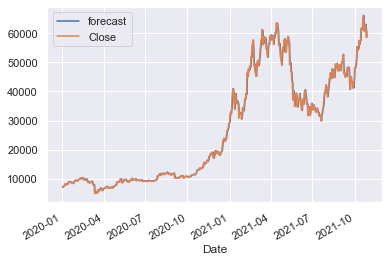

In [48]:
plt.figure(figsize=(20,8))
results_model_310.plot_predict(dynamic=False)
plt.show()

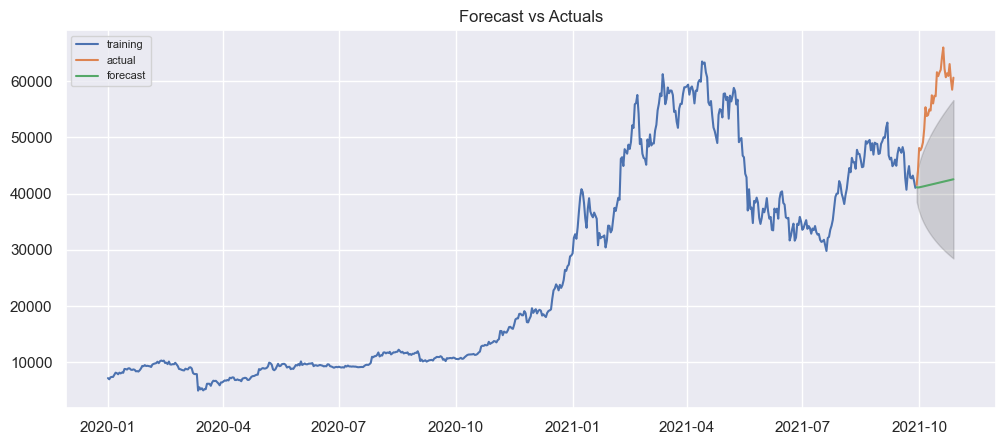

In [49]:
model_310 = ARIMA(train, order=(3, 1, 0))  
fitted = model_310.fit(disp=-1)
# Forecast
fc, se, conf = fitted.forecast(30, alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [50]:
forecast_accuracy(fc, test.values)

{'mape': 0.25161089549671506,
 'me': -14721.457270469136,
 'mae': 14721.457270469136,
 'mpe': -0.25161089549671506,
 'rmse': 15802.538367757481,
 'acf1': 0.8287591033361568,
 'corr': 0.861132829621969,
 'minmax': 0.251610895496715}

## Arima 111

In [51]:
model_arima111 = ARIMA(btc,order=(1,1,1))
results_model_111=model_arima111.fit()
print(results_model_111.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  662
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5706.303
Method:                       css-mle   S.D. of innovations           1340.569
Date:                Fri, 19 Nov 2021   AIC                          11420.605
Time:                        17:01:47   BIC                          11438.586
Sample:                             1   HQIC                         11427.574
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            80.6981     50.064      1.612      0.107     -17.425     178.822
ar.L1.D.Close    -0.4998      0.440     -1.135      0.256      -1.363       0.363
ma.L1.D.Close     0.4410      0.456     

In [52]:
residuals_111 = pd.DataFrame(results_model_111.resid)

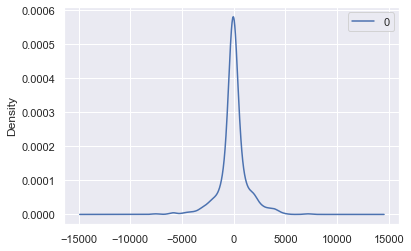

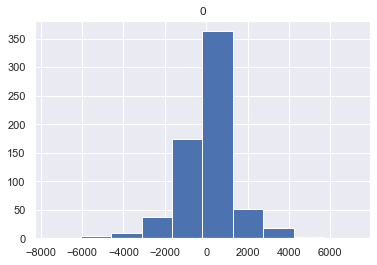

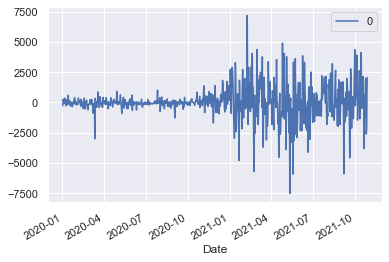

In [53]:
residuals_111.plot(kind='kde')
residuals_111.hist()
residuals_111.plot()
plt.show()

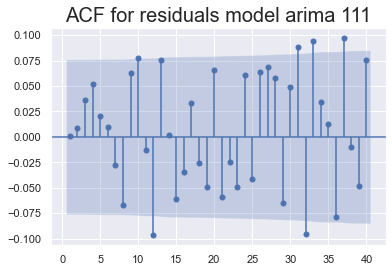

In [54]:
sgt.plot_acf(residuals_111, zero=False, lags=40)
plt.title("ACF for residuals model arima 111", size= 20)
plt.show()

In [55]:
sm.stats.acorr_ljungbox(residuals_111, lags=[4], return_df=True)

,lb_stat,lb_pvalue
4,2.72599,0.604674


In [56]:
shapiro_test_111 = stats.shapiro(residuals_111)
shapiro_test_111

ShapiroResult(statistic=0.8688453435897827, pvalue=4.020017502521999e-23)

Shapiro´s test p-value is near 0, thus residuals are normal distributed.

<Figure size 1440x576 with 0 Axes>

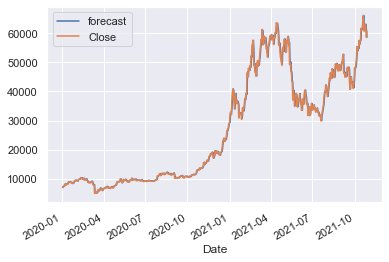

In [57]:
plt.figure(figsize=(20,8))
results_model_111.plot_predict(dynamic=False)
plt.show()

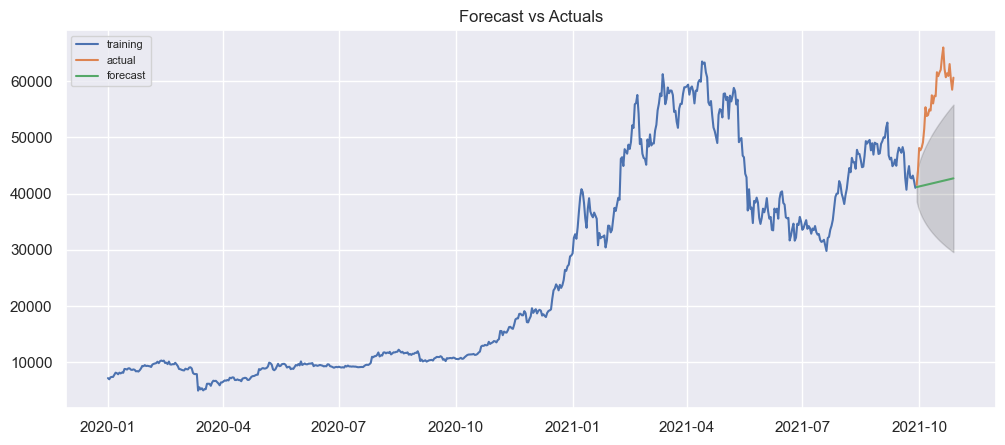

In [58]:
model_111 = ARIMA(train, order=(1, 1, 0))  
fitted = model_111.fit(disp=-1)
# Forecast
fc, se, conf = fitted.forecast(30, alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [59]:
forecast_accuracy(fc, test.values)

{'mape': 0.2488284727455769,
 'me': -14564.320034625154,
 'mae': 14564.320034625154,
 'mpe': -0.2488284727455769,
 'rmse': 15650.959583118994,
 'acf1': 0.830083254912521,
 'corr': 0.87405034937879,
 'minmax': 0.24882847274557685}

## Auto arima

In [60]:
model = auto_arima(btc.dropna(), start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11419.638, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11419.177, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11419.369, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11420.022, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11420.367, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11420.751, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11422.207, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=11419.871, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.137 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  663
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -5706.589
Date:                Fri, 19 Nov 2021   AIC                          11419.177
Time:                       

## Arima 110

In [61]:
model_arima110 = ARIMA(btc,order=(1,1,0))
results_model_110=model_arima110.fit()
print(results_model_110.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  662
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -5706.614
Method:                       css-mle   S.D. of innovations           1341.201
Date:                Fri, 19 Nov 2021   AIC                          11419.227
Time:                        17:01:52   BIC                          11432.713
Sample:                             1   HQIC                         11424.453
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            80.7050     49.164      1.642      0.101     -15.656     177.066
ar.L1.D.Close    -0.0604      0.039     -1.554      0.120      -0.136       0.016
                                    Root

In [62]:
residuals_110 = pd.DataFrame(results_model_110.resid)

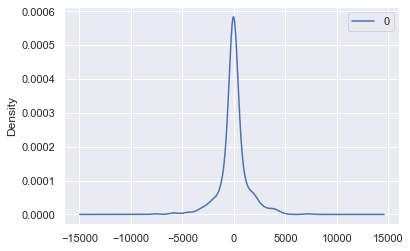

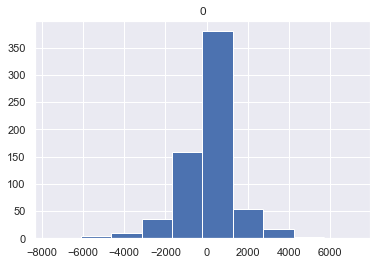

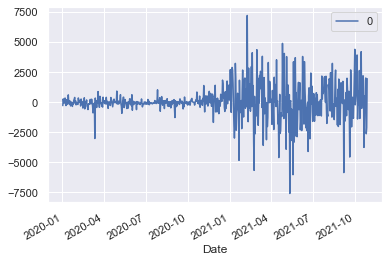

In [63]:
residuals_110.plot(kind='kde')
residuals_110.hist()
residuals_110.plot()
plt.show()

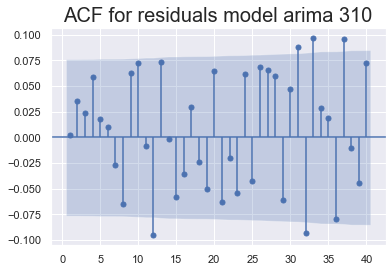

In [64]:
sgt.plot_acf(residuals_110, zero=False, lags=40)
plt.title("ACF for residuals model arima 310", size= 20)
plt.show()

In [65]:
sm.stats.acorr_ljungbox(residuals_110, lags=[4], return_df=True)

,lb_stat,lb_pvalue
4,3.540177,0.471796


In [66]:
shapiro_test_110 = stats.shapiro(residuals_110)
shapiro_test_110

ShapiroResult(statistic=0.8675577640533447, pvalue=3.173463728314192e-23)

Shapiro´s test p-value is near 0, thus residuals are normal distributed.

<Figure size 1440x576 with 0 Axes>

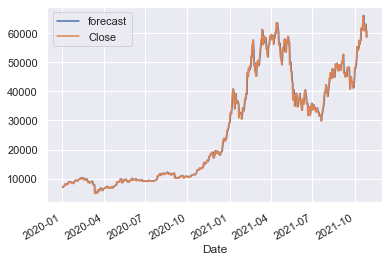

In [67]:
plt.figure(figsize=(20,8))
results_model_110.plot_predict(dynamic=False)
plt.show()

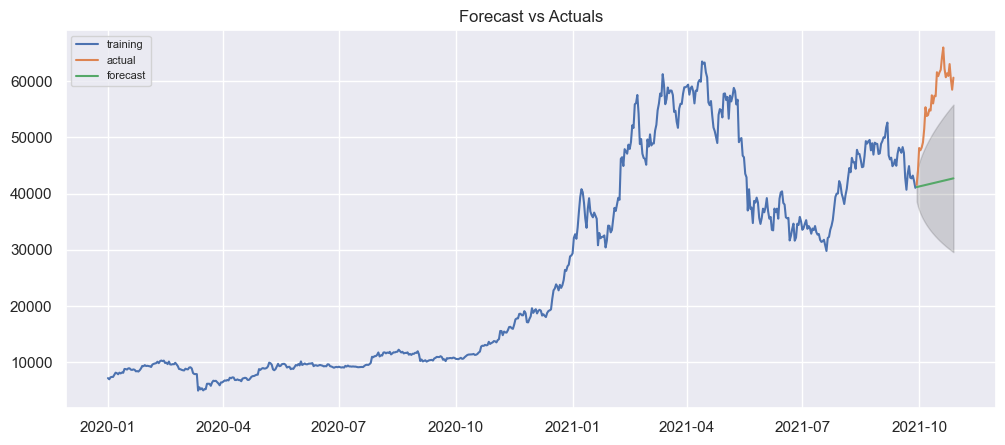

In [68]:
model_110 = ARIMA(train, order=(1, 1, 0))  
fitted = model_110.fit(disp=-1)
# Forecast
fc, se, conf = fitted.forecast(30, alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [69]:
forecast_accuracy(fc, test.values)

{'mape': 0.2488284727455769,
 'me': -14564.320034625154,
 'mae': 14564.320034625154,
 'mpe': -0.2488284727455769,
 'rmse': 15650.959583118994,
 'acf1': 0.830083254912521,
 'corr': 0.87405034937879,
 'minmax': 0.24882847274557685}

# Comparisson of models

In [70]:
def LLR_test(mod_1, mod_2, DF=1):
    "mod_1 = place the first model, mod_2= place your second model, DF = degrees of freedom, 1 degree of freedom by default"
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

In [71]:
print ("LLR test: " + str(LLR_test(model_arima510, model_arima410, DF=1)))

LLR test: 1.0


In [72]:
print ("LLR test: " + str(LLR_test(model_arima510, model_arima310, DF=2)))

LLR test: 1.0


In [73]:
print ("LLR test: " + str(LLR_test(model_arima510, model_arima111, DF=3)))

LLR test: 1.0


**We can see that the best model is arima 111**

In [74]:
log_btc = np.log(btc)
log_btc

Date
2020-01-01     8.881861
2020-01-02     8.851588
2020-01-03     8.901759
2020-01-04     8.910674
2020-01-05     8.910763
                ...    
2021-10-24    11.017495
2021-10-25    11.051522
2021-10-26    11.008145
2021-10-27    10.976481
2021-10-28    11.012415
Name: Close, Length: 663, dtype: float64

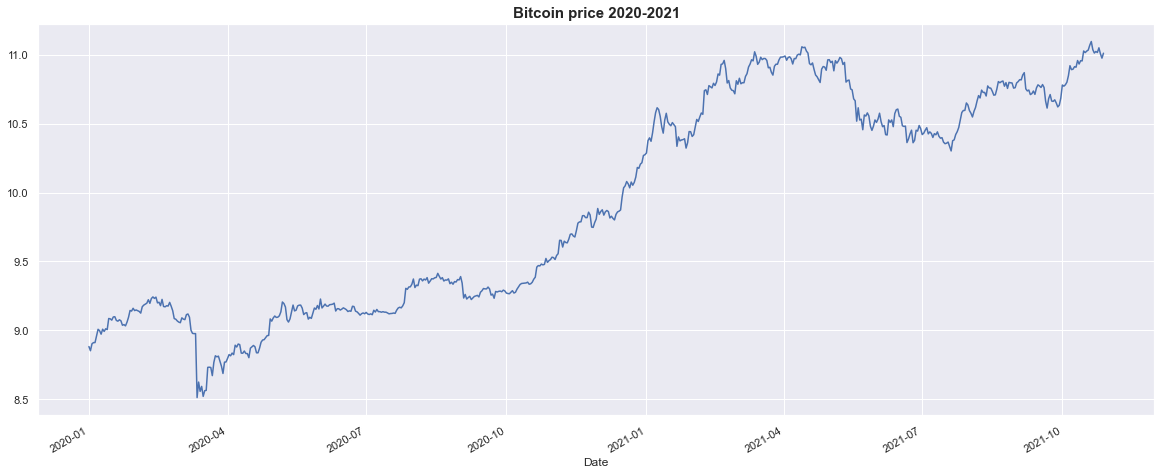

In [75]:
log_btc.plot(figsize=(20,8))
plt.title('Bitcoin price 2020-2021', fontsize=15, weight='bold')
plt.show()

In [76]:
sts.adfuller(log_btc)

(-0.6251285289351216,
 0.8652023219101741,
 4,
 658,
 {'1%': -3.4403271946832645,
  '5%': -2.8659424728408456,
  '10%': -2.5691144817582985},
 -2244.4877326374544)